# Auto MPG — Regression Modeling & Performance Dashboard

This notebook:
- Loads cleaned dataset from Notebook 1
- Performs univariate & multivariate regression
- Trains Linear, Polynomial, PWLF, Random Forest models
- Generates evaluation metrics
- Produces diagnostic plots
- Builds an interactive Plotly dashboard


In [22]:
#!pip install pwlf

In [36]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pwlf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator, RegressorMixin

sns.set(style="whitegrid")


In [37]:
#Load cleaned dataset
df = pd.read_csv("auto_mpg_cleaned.csv")
df.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,name,hp_to_weight,car_age,origin_japan,origin_usa
0,18.0,8,1.090604,0.673118,0.630870,-1.295498,70,chevrolet chevelle malibu,0.369595,1.627426,False,True
1,15.0,8,1.503514,1.589958,0.854333,-1.477038,70,buick skylark 320,1.638144,1.627426,False,True
2,18.0,8,1.196232,1.197027,0.550470,-1.658577,70,plymouth satellite,1.466791,1.627426,False,True
3,16.0,8,1.061796,1.197027,0.546923,-1.295498,70,amc rebel sst,1.473177,1.627426,False,True
4,17.0,8,1.042591,0.935072,0.565841,-1.840117,70,ford torino,0.953937,1.627426,False,True


In [38]:
#Define regression metrics function
def regression_metrics(y_true, y_pred, p):
    n = len(y_true)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    return {
        "R2": r2,
        "Adj_R2": adj_r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    }


In [39]:
class SegmentedLinearRegressor(BaseEstimator, RegressorMixin):
    """
    Piecewise Linear Regression (Multivariate)
    Uses a Decision Tree to create regions,
    then fits a Linear Regression inside each region.
    """
    def __init__(self, n_segments=4):
        self.n_segments = n_segments
        self.partitioner_ = None
        self.models_ = {}

    def fit(self, X, y):
        self.partitioner_ = DecisionTreeRegressor(
            max_leaf_nodes=self.n_segments,
            random_state=42
        )
        self.partitioner_.fit(X, y)

        # assign linear models to each tree leaf
        leaf_idx = self.partitioner_.apply(X)
        unique_leaves = np.unique(leaf_idx)

        for leaf in unique_leaves:
            mask = (leaf_idx == leaf)
            X_sub = X[mask]
            y_sub = y[mask]

            # Ridge for stability
            model = Ridge(alpha=1.0)
            model.fit(X_sub, y_sub)
            self.models_[leaf] = model

        return self

    def predict(self, X):
        leaf_idx = self.partitioner_.apply(X)
        y_pred = np.zeros(len(X))

        for leaf in np.unique(leaf_idx):
            mask = (leaf_idx == leaf)
            if leaf in self.models_:
                y_pred[mask] = self.models_[leaf].predict(X[mask])
            else:
                # fallback (should rarely occur)
                y_pred[mask] = np.mean([m.coef_[0] for m in self.models_.values()])

        return y_pred


### UNIVARIATE REGRESSION (hp → mpg)

In [40]:
#Prepare data
X_hp = df[["horsepower"]].values
y_hp = df["mpg"].values

X_hp_train, X_hp_test, y_hp_train, y_hp_test = train_test_split(
    X_hp, y_hp, test_size=0.2, random_state=42
)


In [41]:
# Fit Linear + Polynomial + PWLF
lin_hp = LinearRegression().fit(X_hp_train, y_hp_train)

poly_hp = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin", LinearRegression())
])
poly_hp.fit(X_hp_train, y_hp_train)


,steps,"[('poly', ...), ('lin', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [42]:
pw = pwlf.PiecewiseLinFit(X_hp.flatten(), y_hp)
breaks = pw.fit(3)
breaks

array([-1.52729973, -1.49173104, -0.03641774,  3.29266208])

### Univariate models: hp → mpg with fitted curves on scatter¶
This assumes you fit:

lin_hp = LinearRegression on horsepower only

poly_hp = Pipeline(PolynomialFeatures + LinearRegression) on horsepower

pw = pwlf.PiecewiseLinFit model on horsepower

In [43]:
# Use only rows with non-null hp & mpg
df_uni = df.dropna(subset=["horsepower", "mpg"]).copy()
X_hp = df_uni[["horsepower"]].values
y_hp = df_uni["mpg"].values

X_hp_train, X_hp_test, y_hp_train, y_hp_test = train_test_split(
    X_hp, y_hp, test_size=0.2, random_state=42
)

# 1) Linear regression (univariate)
lin_hp = LinearRegression()
lin_hp.fit(X_hp_train, y_hp_train)

# 2) Polynomial regression (degree 2)
poly_hp = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin", LinearRegression())
])
poly_hp.fit(X_hp_train, y_hp_train)

# 3) Piecewise Linear Regression (PWLF) on full hp/ mpg
hp_all = X_hp.flatten()
mpg_all = y_hp
pw = pwlf.PiecewiseLinFit(hp_all, mpg_all)
breaks = pw.fit(3)   # 3 segments (you can tune)
print("PWLF breakpoints:", breaks)


PWLF breakpoints: [-1.52729973 -0.11274572  1.4386358   3.29266208]


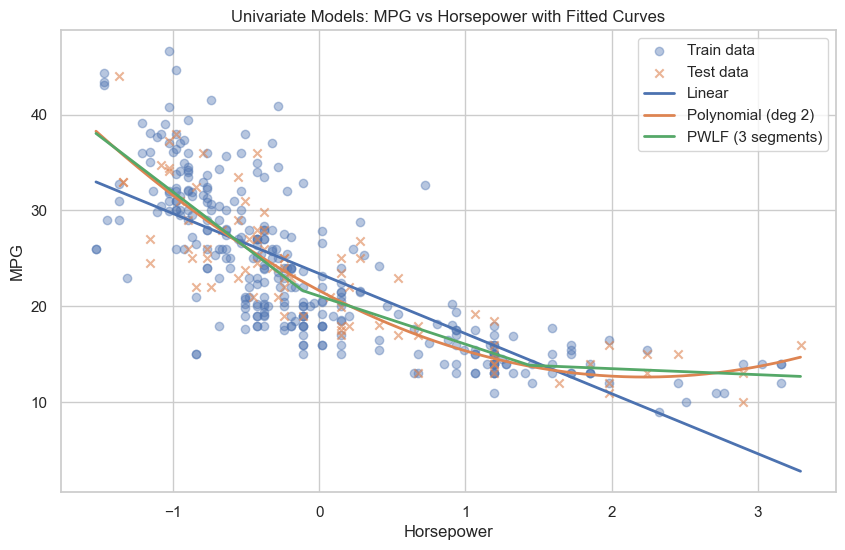

In [44]:
# Plot fitted curves on scatter
# Plot scatter + fitted curves for all 3
# Grid of horsepower from min to max
hp_grid = np.linspace(hp_all.min(), hp_all.max(), 300).reshape(-1, 1)

# Predictions
y_lin_grid = lin_hp.predict(hp_grid)
y_poly_grid = poly_hp.predict(hp_grid)
y_pw_grid   = pw.predict(hp_grid.flatten())

plt.figure(figsize=(10,6))
plt.scatter(X_hp_train, y_hp_train, alpha=0.4, label="Train data")
plt.scatter(X_hp_test, y_hp_test, alpha=0.6, label="Test data", marker="x")

plt.plot(hp_grid, y_lin_grid, label="Linear", linewidth=2)
plt.plot(hp_grid, y_poly_grid, label="Polynomial (deg 2)", linewidth=2)
plt.plot(hp_grid, y_pw_grid, label="PWLF (3 segments)", linewidth=2)

plt.xlabel("Horsepower")
plt.ylabel("MPG")
plt.title("Univariate Models: MPG vs Horsepower with Fitted Curves")
plt.legend()
plt.show()


### MULTIVARIATE REGRESSION

In [45]:
# Select features

# Add ALL origin_* columns that exist
origin_cols = [col for col in df.columns if col.startswith("origin")]
feature_cols = [
    "horsepower", "weight", "displacement",
    "cylinders", "model_year",
    "hp_to_weight", "car_age"
] + origin_cols

print("Final features:", feature_cols)


Final features: ['horsepower', 'weight', 'displacement', 'cylinders', 'model_year', 'hp_to_weight', 'car_age', 'origin_japan', 'origin_usa']


In [46]:
X = df[feature_cols]
y = df["mpg"]


In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (318, 9) (318,)
Test shapes: (80, 9) (80,)


In [48]:
#Train models
# Linear multi
lin_multi = LinearRegression()
lin_multi.fit(X_train, y_train)
y_pred_lin = lin_multi.predict(X_test)

# Polynomial multi
poly2_multi = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin", LinearRegression())
])
poly2_multi.fit(X_train, y_train)
y_pred_poly2 = poly2_multi.predict(X_test)

# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    min_samples_leaf=3,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Custom PWLR
pwlr_multi = Pipeline([
    ("scaler", StandardScaler()),
    ("segmented", SegmentedLinearRegressor(n_segments=4))
])

pwlr_multi.fit(X_train, y_train)
y_pred_pwlr = pwlr_multi.predict(X_test)


### EVALUATION & DASHBOARD

In [49]:
#Build results table
results = []

# Univariate Linear
y_pred = lin_hp.predict(X_hp_test)
m = regression_metrics(y_hp_test, y_pred, p=1)
m["Model"] = "Linear (hp)"
results.append(m)

# Univariate Poly
y_pred = poly_hp.predict(X_hp_test)
m = regression_metrics(y_hp_test, y_pred, p=2)
m["Model"] = "Poly deg2 (hp)"
results.append(m)

# Univariate PWLF
y_pred = pw.predict(X_hp_test.flatten())
m = regression_metrics(y_hp_test, y_pred, p=3)
m["Model"] = "PWLF (hp)"
results.append(m)

# Multivariate Linear
m = regression_metrics(y_test, y_pred_lin, p=X_test.shape[1])
m['Model'] = "Linear (multi)"
results.append(m)

# Polynomial multi
X_test_poly = poly2_multi.named_steps["poly"].transform(X_test)
p_poly = X_test_poly.shape[1]
m = regression_metrics(y_test, y_pred_poly2, p=p_poly)
m['Model'] = "Poly deg2 (multi)"
results.append(m)

# Random forest
m = regression_metrics(y_test, y_pred_rf, p=X_test.shape[1])
m['Model'] = "Random Forest"
results.append(m)

# Custom PWLR
m = regression_metrics(y_test, y_pred_pwlr, p=X_test.shape[1])
m['Model'] = "Piecewise Linear (Custom Multi)"
results.append(m)

results_df = pd.DataFrame(results)
results_df


,R2,Adj_R2,MSE,RMSE,MAE,Model
0,0.639680,0.635060,19.373139,4.401493,3.508906,Linear (hp)
1,0.740709,0.733974,13.941159,3.733786,2.920696,Poly deg2 (hp)
2,0.740440,0.730194,13.955627,3.735723,2.929071,PWLF (hp)
3,0.855044,0.836406,7.793787,2.791736,2.222207,Linear (multi)
4,0.898055,0.677853,5.481227,2.341202,1.723561,Poly deg2 (multi)
5,0.923511,0.913677,4.112521,2.027935,1.571305,Random Forest
6,0.901119,0.888406,5.316486,2.305751,1.646580,Piecewise Linear (Custom Multi)


### Diagnostic charts for multivariate models
4.1 Predicted vs Actual for each model

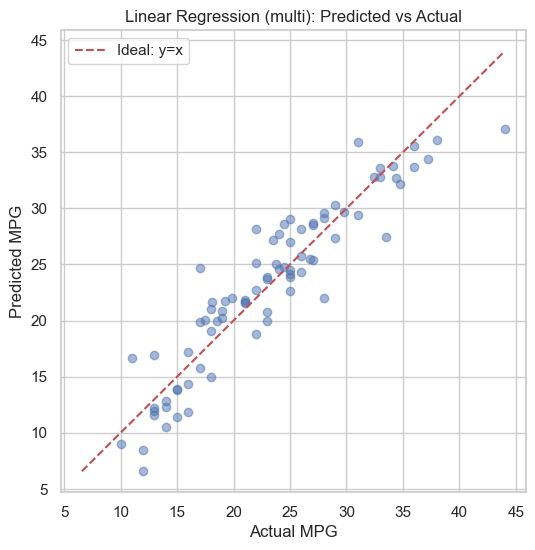

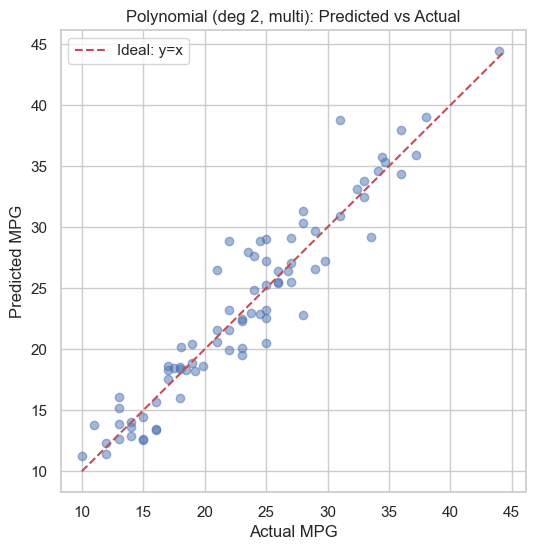

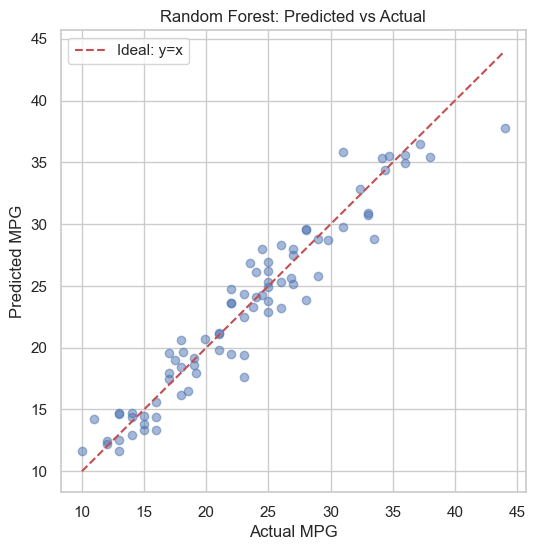

In [50]:
def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="Ideal: y=x")
    plt.xlabel("Actual MPG")
    plt.ylabel("Predicted MPG")
    plt.title(title)
    plt.legend()
    plt.show()

plot_pred_vs_actual(y_test, y_pred_lin,  "Linear Regression (multi): Predicted vs Actual")
plot_pred_vs_actual(y_test, y_pred_poly2,"Polynomial (deg 2, multi): Predicted vs Actual")
plot_pred_vs_actual(y_test, y_pred_rf,   "Random Forest: Predicted vs Actual")


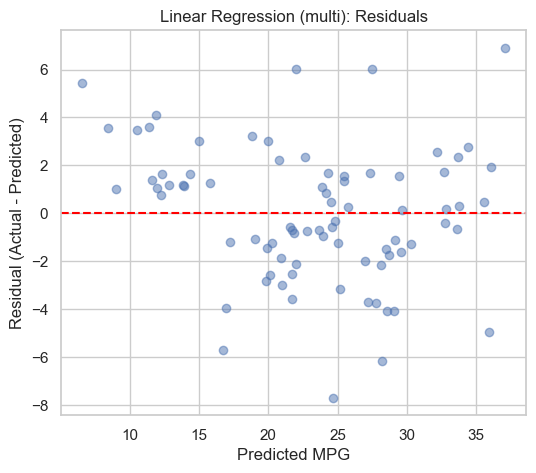

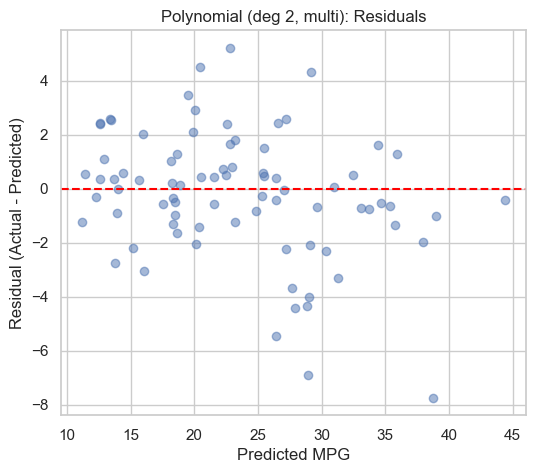

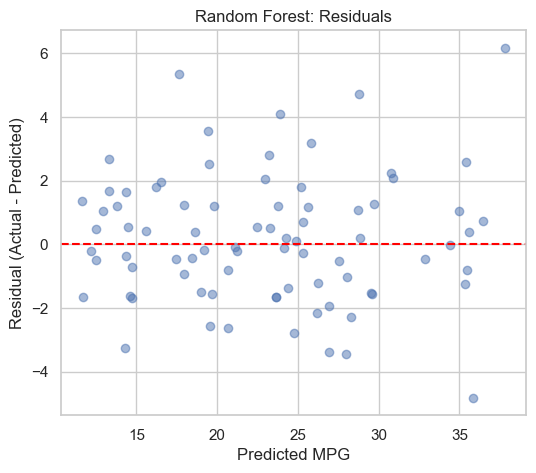

In [51]:
#4.2 Residual plots
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted MPG")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(title)
    plt.show()

plot_residuals(y_test, y_pred_lin,   "Linear Regression (multi): Residuals")
plot_residuals(y_test, y_pred_poly2, "Polynomial (deg 2, multi): Residuals")
plot_residuals(y_test, y_pred_rf,    "Random Forest: Residuals")


### Compute metrics for all models + results table
We’ll gather:

Univariate: lin_hp, poly_hp, pw (evaluated on test hp)

Multivariate: lin_multi, poly2_multi, rf

In [52]:
results = []

# -------------------------------
# Univariate Linear (hp -> mpg)
# -------------------------------
y_hp_pred_lin_test = lin_hp.predict(X_hp_test)
m_lin_uni = regression_metrics(y_hp_test, y_hp_pred_lin_test, p=1)
m_lin_uni["Model"] = "Linear (hp→mpg)"
results.append(m_lin_uni)

# -------------------------------
# Univariate Polynomial (hp -> mpg)
# -------------------------------
y_hp_pred_poly_test = poly_hp.predict(X_hp_test)
p_poly_uni = poly_hp.named_steps["poly"].n_output_features_

m_poly_uni = regression_metrics(y_hp_test, y_hp_pred_poly_test, p=p_poly_uni)
m_poly_uni["Model"] = "Polynomial deg 2 (hp→mpg)"
results.append(m_poly_uni)

# -------------------------------
# Univariate PWLF
# -------------------------------
y_hp_pred_pw_test = pw.predict(X_hp_test.flatten())
m_pw_uni = regression_metrics(y_hp_test, y_hp_pred_pw_test, p=3)
m_pw_uni["Model"] = "PWLF (hp→mpg)"
results.append(m_pw_uni)

# -------------------------------
# Multivariate Linear
# -------------------------------
m_lin_multi = regression_metrics(y_test, y_pred_lin, p=X_test.shape[1])
m_lin_multi["Model"] = "Linear (multi)"
results.append(m_lin_multi)

# -------------------------------
# Multivariate Polynomial deg 2
# -------------------------------
# FIX: Compute number of polynomial features
p_poly2 = poly2_multi.named_steps["poly"].transform(X_test).shape[1]

m_poly_multi = regression_metrics(y_test, y_pred_poly2, p=p_poly2)
m_poly_multi["Model"] = "Polynomial deg 2 (multi)"
results.append(m_poly_multi)

# -------------------------------
# Random Forest
# -------------------------------
m_rf = regression_metrics(y_test, y_pred_rf, p=X_test.shape[1])
m_rf["Model"] = "Random Forest (multi)"
results.append(m_rf)

# -------------------------------
# PWLR
# -------------------------------
m_pw_c = regression_metrics(y_test, y_pred_pwlr, p=X_test.shape[1])
m_pw_c["Model"] = "Piecewise Linear (Custom Multi)"
results.append(m_pw_c)

# -------------------------------
# Create Results Table
# -------------------------------
results_df = pd.DataFrame(results)
results_df = results_df[["Model", "R2", "Adj_R2", "MSE", "RMSE", "MAE"]]

results_df.sort_values("RMSE")


,Model,R2,Adj_R2,MSE,RMSE,MAE
5,Random Forest (multi),0.923511,0.913677,4.112521,2.027935,1.571305
6,Piecewise Linear (Custom Multi),0.901119,0.888406,5.316486,2.305751,1.646580
4,Polynomial deg 2 (multi),0.898055,0.677853,5.481227,2.341202,1.723561
3,Linear (multi),0.855044,0.836406,7.793787,2.791736,2.222207
1,Polynomial deg 2 (hp→mpg),0.740709,0.733974,13.941159,3.733786,2.920696
2,PWLF (hp→mpg),0.740440,0.730194,13.955627,3.735723,2.929071
0,Linear (hp→mpg),0.639680,0.635060,19.373139,4.401493,3.508906


### MODEL PERFORMANCE DASHBOARD (Auto MPG)
This dashboard includes:

R² comparison bar chart

RMSE comparison bar chart

MAE comparison bar chart

Performance heatmap

Final sorted table

In [53]:
# setup 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})


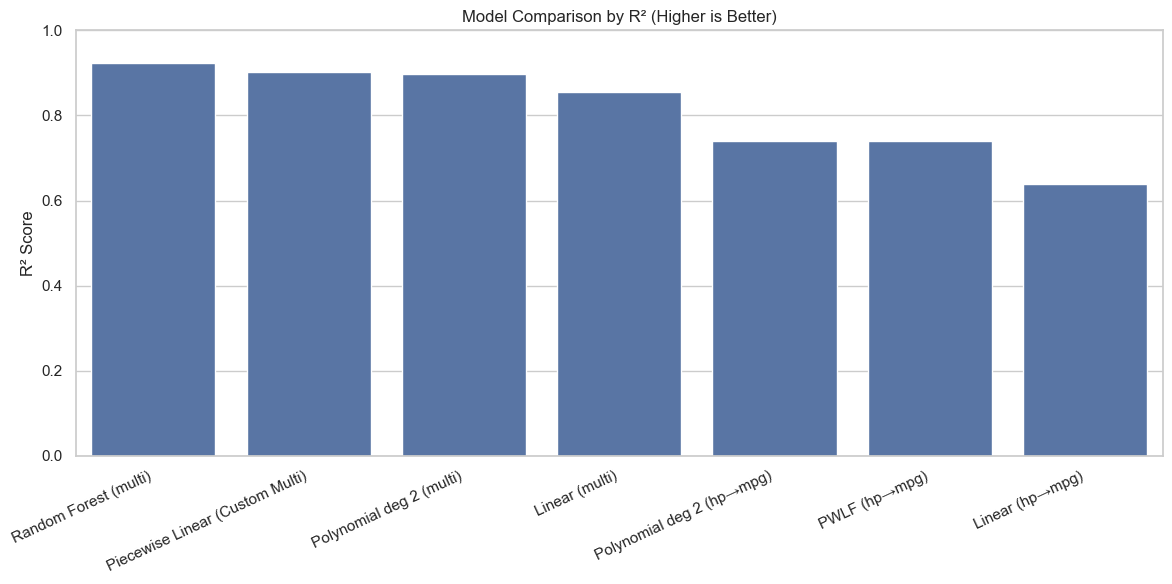

In [54]:
# 2. R² Comparison Chart
plt.figure(figsize=(12,6))
order_r2 = results_df.sort_values("R2", ascending=False)["Model"]
sns.barplot(data=results_df, x="Model", y="R2", order=order_r2)
plt.title("Model Comparison by R² (Higher is Better)")
plt.ylabel("R² Score")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


/var/folders/xf/tmvw9nzd6lb5ct87w5pzymmc0000gn/T/ipykernel_2097/769628183.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", order=order_rmse, palette="Blues_r")


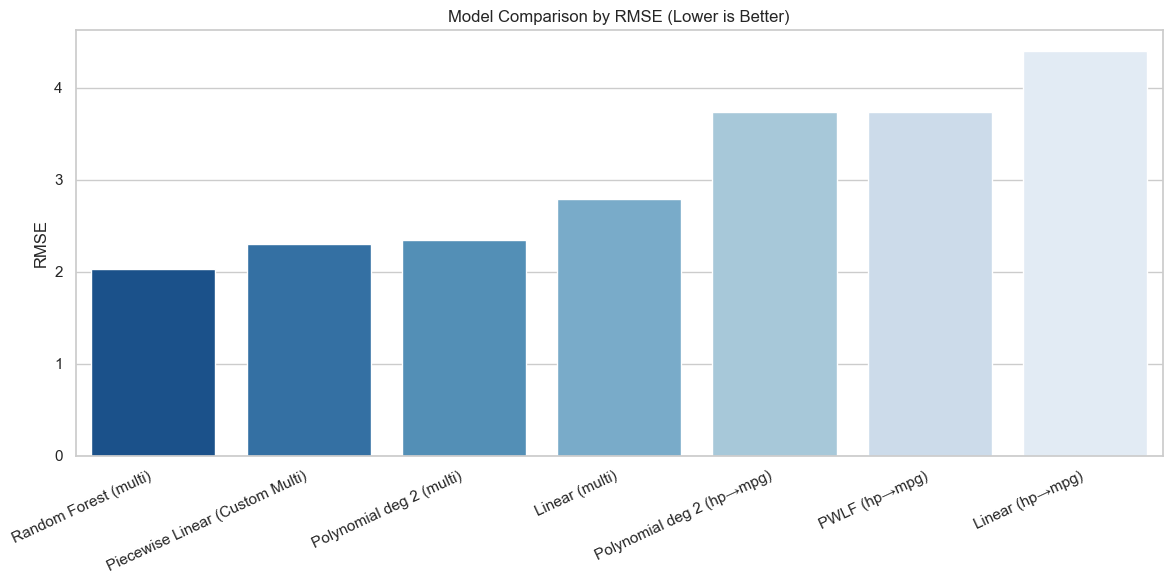

In [55]:
# RMSE
plt.figure(figsize=(12,6))
order_rmse = results_df.sort_values("RMSE")["Model"]
sns.barplot(data=results_df, x="Model", y="RMSE", order=order_rmse, palette="Blues_r")
plt.title("Model Comparison by RMSE (Lower is Better)")
plt.ylabel("RMSE")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


/var/folders/xf/tmvw9nzd6lb5ct87w5pzymmc0000gn/T/ipykernel_2097/2504931162.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", order=order_mae, palette="Greens_r")


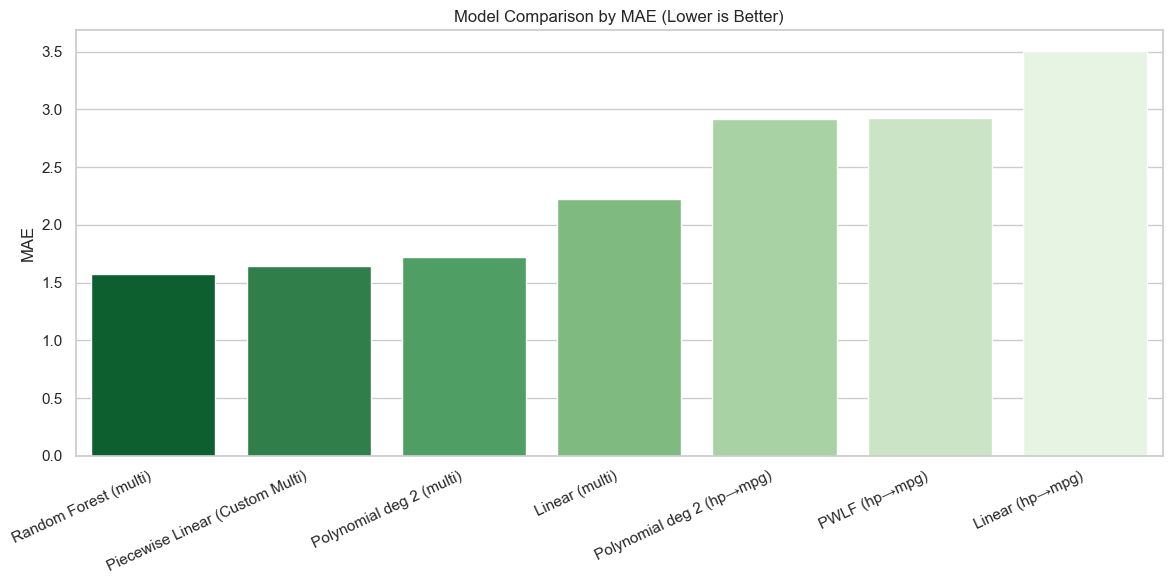

In [56]:
# MAE
plt.figure(figsize=(12,6))
order_mae = results_df.sort_values("MAE")["Model"]
sns.barplot(data=results_df, x="Model", y="MAE", order=order_mae, palette="Greens_r")
plt.title("Model Comparison by MAE (Lower is Better)")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=25, ha="right")
plt.tight_layout()
plt.show()


In [57]:
# heatmap
heatmap_df = results_df.set_index("Model")[["R2", "RMSE", "MAE"]]


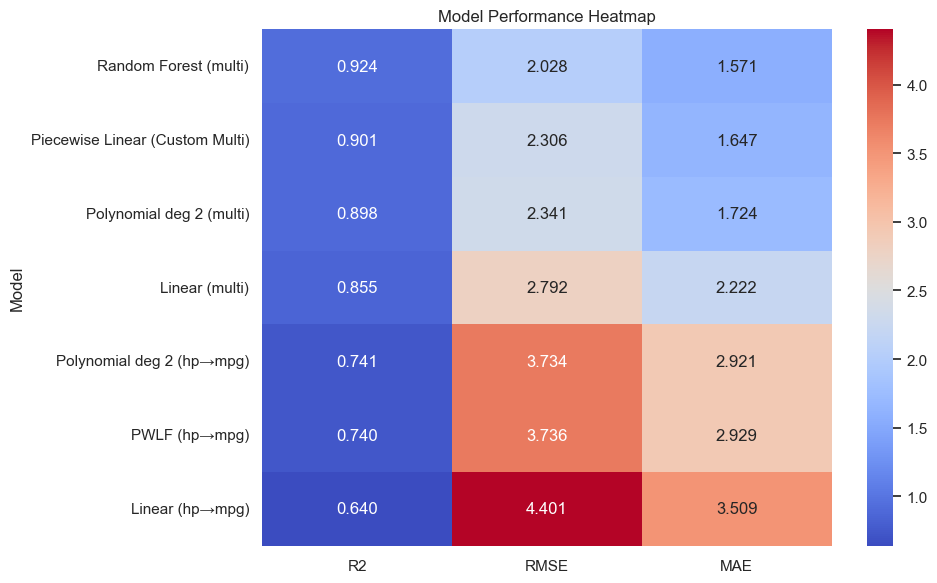

In [58]:
plt.figure(figsize=(10,6))
heatmap_sorted = heatmap_df.loc[order_rmse]
sns.heatmap(heatmap_sorted, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Model Performance Heatmap")
plt.tight_layout()
plt.show()


In [59]:
display(
    results_df.sort_values("RMSE").reset_index(drop=True)
)


,Model,R2,Adj_R2,MSE,RMSE,MAE
0,Random Forest (multi),0.923511,0.913677,4.112521,2.027935,1.571305
1,Piecewise Linear (Custom Multi),0.901119,0.888406,5.316486,2.305751,1.646580
2,Polynomial deg 2 (multi),0.898055,0.677853,5.481227,2.341202,1.723561
3,Linear (multi),0.855044,0.836406,7.793787,2.791736,2.222207
4,Polynomial deg 2 (hp→mpg),0.740709,0.733974,13.941159,3.733786,2.920696
5,PWLF (hp→mpg),0.740440,0.730194,13.955627,3.735723,2.929071
6,Linear (hp→mpg),0.639680,0.635060,19.373139,4.401493,3.508906


In [60]:
# Interactive Bar Charts (RMSE, R², MAE)
import plotly.express as px

# RMSE
fig_rmse = px.bar(
    results_df.sort_values("RMSE"),
    x="Model",
    y="RMSE",
    title="Interactive RMSE Comparison",
    text_auto=".2f",
    color="RMSE",
    color_continuous_scale="Blues_r"
)
fig_rmse.update_layout(xaxis_tickangle=-25, height=500)
fig_rmse.show()

# R2
fig_r2 = px.bar(
    results_df.sort_values("R2", ascending=False),
    x="Model",
    y="R2",
    title="Interactive R² Comparison",
    text_auto=".3f",
    color="R2",
    color_continuous_scale="Greens"
)
fig_r2.update_layout(xaxis_tickangle=-25, height=500)
fig_r2.show()

# MAE
fig_mae = px.bar(
    results_df.sort_values("MAE"),
    x="Model",
    y="MAE",
    title="Interactive MAE Comparison",
    text_auto=".2f",
    color="MAE",
    color_continuous_scale="Reds_r"
)
fig_mae.update_layout(xaxis_tickangle=-25, height=500)
fig_mae.show()


ModuleNotFoundError: No module named 'plotly'

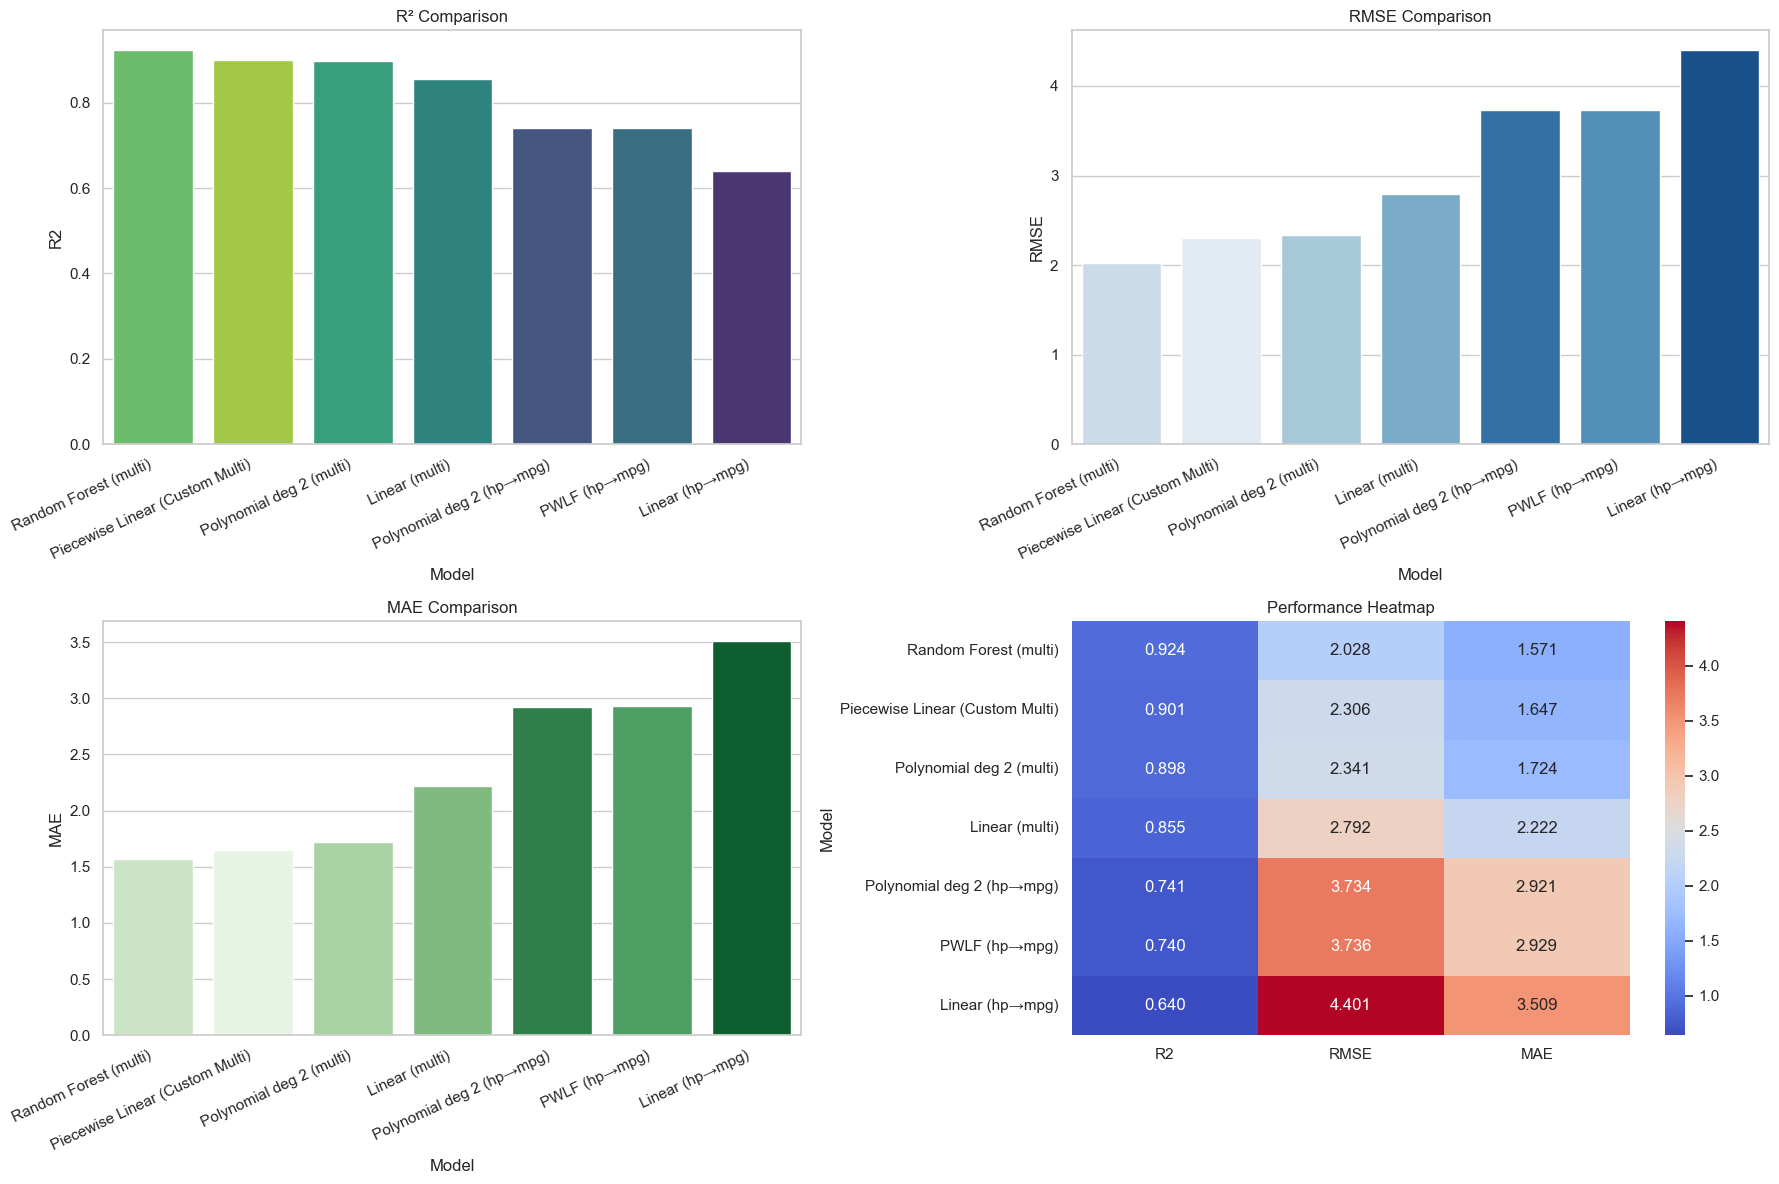

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))

# -----------------------------
# 1. R² Chart
# -----------------------------
sns.barplot(data=results_df, x="Model", y="R2",
            order=order_r2, hue="Model", dodge=False, legend=False,
            ax=axes[0,0], palette="viridis")
axes[0,0].set_title("R² Comparison")
axes[0,0].set_xticks(range(len(order_r2)))
axes[0,0].set_xticklabels(order_r2, rotation=25, ha="right")

# -----------------------------
# 2. RMSE Chart
# -----------------------------
sns.barplot(data=results_df, x="Model", y="RMSE",
            order=order_rmse, hue="Model", dodge=False, legend=False,
            ax=axes[0,1], palette="Blues_r")
axes[0,1].set_title("RMSE Comparison")
axes[0,1].set_xticks(range(len(order_rmse)))
axes[0,1].set_xticklabels(order_rmse, rotation=25, ha="right")

# -----------------------------
# 3. MAE Chart
# -----------------------------
sns.barplot(data=results_df, x="Model", y="MAE",
            order=order_mae, hue="Model", dodge=False, legend=False,
            ax=axes[1,0], palette="Greens_r")
axes[1,0].set_title("MAE Comparison")
axes[1,0].set_xticks(range(len(order_mae)))
axes[1,0].set_xticklabels(order_mae, rotation=25, ha="right")

# -----------------------------
# 4. Heatmap
# -----------------------------
# Sort heatmap rows by RMSE ascending (best model first)
heatmap_sorted = heatmap_df.loc[order_rmse]
sns.heatmap(heatmap_sorted, annot=True, cmap="coolwarm",
            fmt=".3f", ax=axes[1,1])
axes[1,1].set_title("Performance Heatmap")

plt.tight_layout()
plt.show()


## Feature Importance Chart

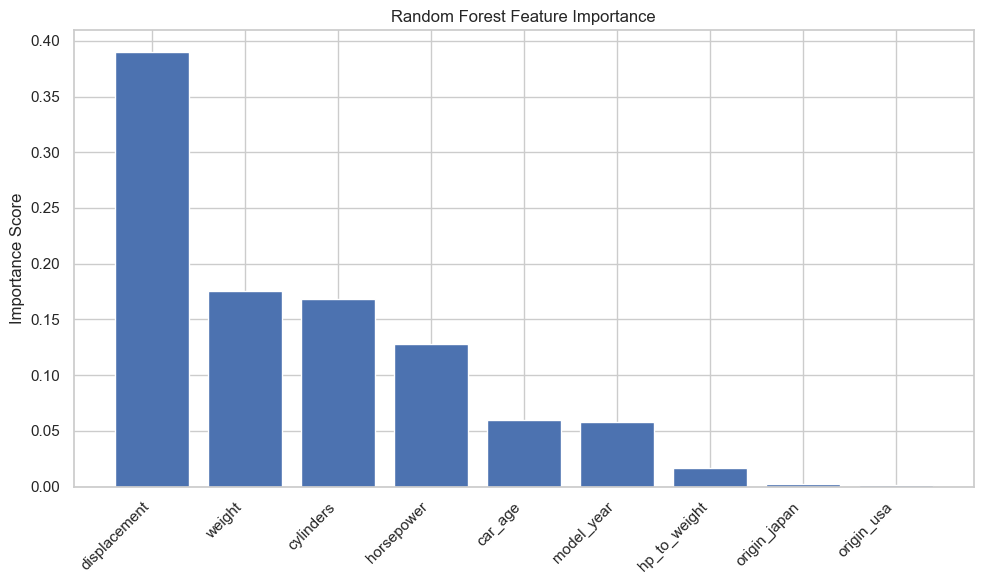

'\nRandom Forest identifies weight, displacement, and horsepower as the strongest predictors of MPG, \nfollowed by hp-to-weight ratio and model_year. This visualization supports the nonlinear nature of the \ntarget and explains why multivariate Random Forest significantly outperforms univariate models.\n'

In [62]:
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=45, ha="right")
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

"""
Random Forest identifies weight, displacement, and horsepower as the strongest predictors of MPG, 
followed by hp-to-weight ratio and model_year. This visualization supports the nonlinear nature of the 
target and explains why multivariate Random Forest significantly outperforms univariate models.
"""


### Partial Dependence Plots (PDP) – Shows how a feature affects MPG

Helps visualize non-linear effects learned by Random Forest.

<Figure size 1000x800 with 0 Axes>

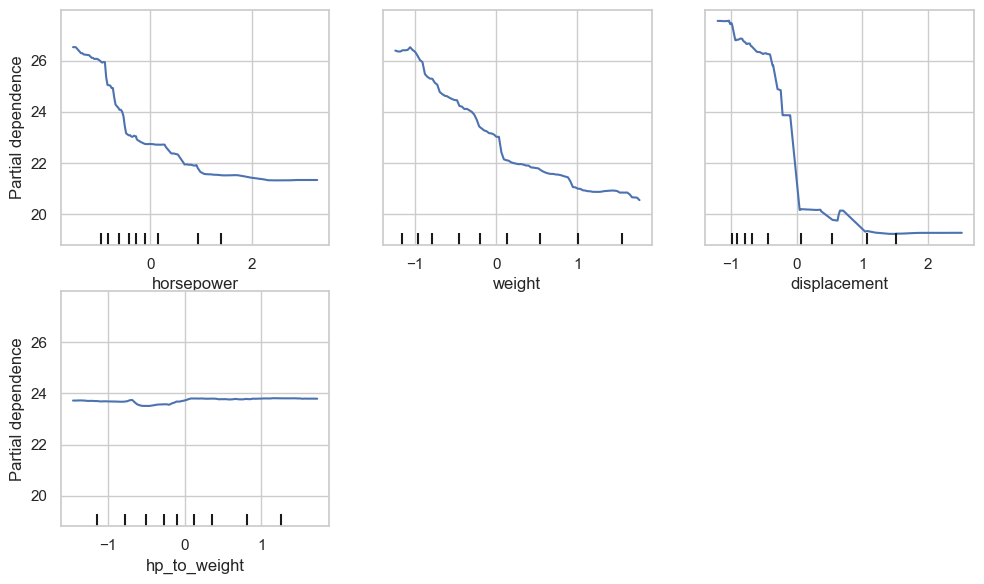

'\nPartial dependence plots reveal nonlinear relationships, such as MPG decreasing sharply at low \nhorsepower and then flattening at high horsepower levels. These curves demonstrate Random Forest’s \nability to model complex behaviors that linear models cannot.\n'

In [63]:
from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10,8))
PartialDependenceDisplay.from_estimator(
    rf, X, ["horsepower", "weight", "displacement", "hp_to_weight"], 
    kind="average", 
    subsample=200
)
plt.tight_layout()
plt.show()

"""
Partial dependence plots reveal nonlinear relationships, such as MPG decreasing sharply at low 
horsepower and then flattening at high horsepower levels. These curves demonstrate Random Forest’s 
ability to model complex behaviors that linear models cannot.
"""

### Random Forest Residual Plot
Shows how accurate predictions are relative to true values.

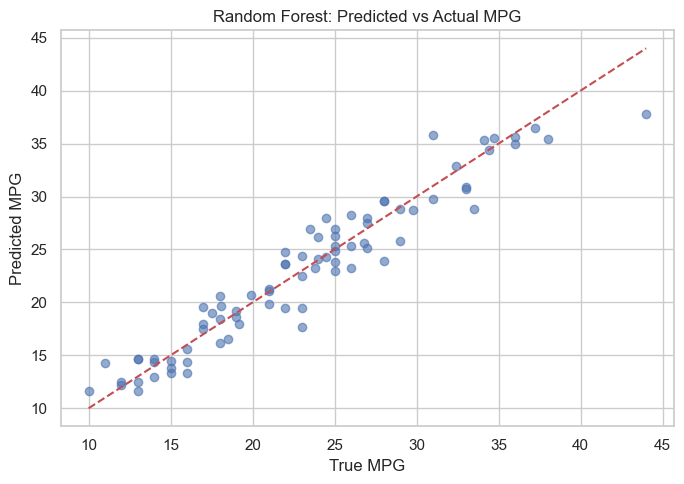

'\nThe residual scatter plot shows points clustered tightly around the diagonal, indicating high prediction accuracy with minimal systematic bias.\n'

In [64]:
y_pred_rf = rf.predict(X_test)

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred_rf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True MPG")
plt.ylabel("Predicted MPG")
plt.title("Random Forest: Predicted vs Actual MPG")
plt.tight_layout()
plt.show()

"""
The residual scatter plot shows points clustered tightly around the diagonal, indicating high prediction accuracy with minimal systematic bias.
"""

### Residual Distribution Plot

Visualizes error magnitude and symmetry.

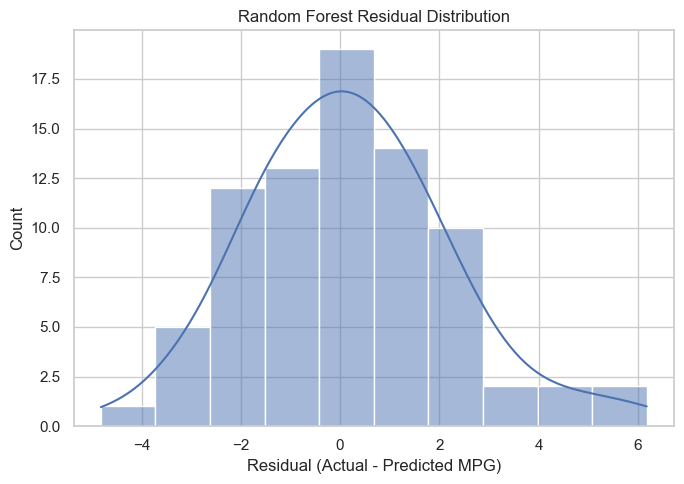

'\nThe residual distribution is centered around zero with low variance, confirming Random Forest’s stable and unbiased predictions.\n'

In [65]:
residuals = y_test - y_pred_rf

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True)
plt.title("Random Forest Residual Distribution")
plt.xlabel("Residual (Actual - Predicted MPG)")
plt.tight_layout()
plt.show()

"""
The residual distribution is centered around zero with low variance, confirming Random Forest’s stable and unbiased predictions.
"""

In [66]:
!pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 8.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 10.8 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [shap]5/6 [shap]]te]


/opt/anaconda3/envs/ML/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


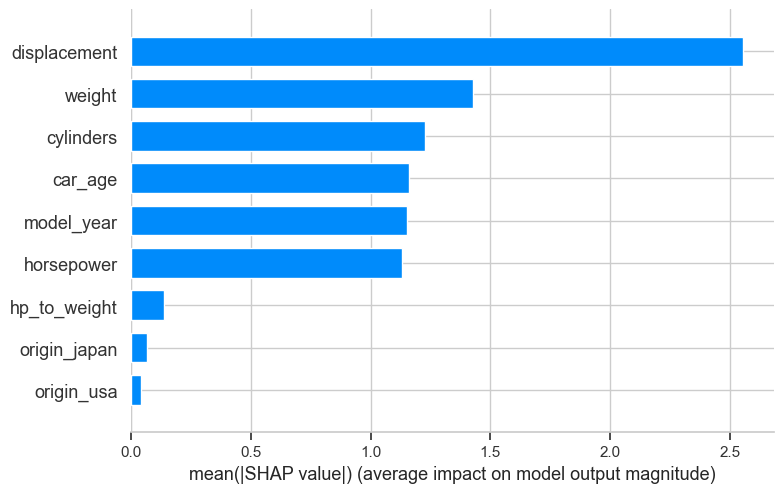

'\nSHAP analysis provides detailed interpretability, confirming that weight and displacement influence \nMPG the most, with nonlinear and interacting effects captured by the Random Forest.\n'

In [67]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

"""
SHAP analysis provides detailed interpretability, confirming that weight and displacement influence 
MPG the most, with nonlinear and interacting effects captured by the Random Forest.
"""